# Imports

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)#set  random seed for reproducability
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from keras.models import Sequential
from keras.layers import Dense
import gmaps

# Load Data and Merge

In [45]:
arrest_data = pd.read_csv("arrests_w_census_loc.csv")
arrest_data.PERP_RACE[arrest_data.PERP_RACE.str.contains("WHITE")]=0
arrest_data.PERP_RACE[arrest_data.PERP_RACE != 0]=1
arrest_data = arrest_data.groupby(["PERP_RACE","BlockLocation"]).size().reset_index(name='counts')
blockLocation = arrest_data["BlockLocation"]
blockLat = [float(re.findall(r'[-\d\.]+', bl)[0]) for bl in blockLocation]
blockLon = [float(re.findall(r'[-\d\.]+', bl)[1]) for bl in blockLocation]
arrest_data["blockLat"]=blockLat
arrest_data["blockLon"]=blockLon
arrest_data = arrest_data.drop("BlockLocation", axis=1)
arrest_data = arrest_data.rename(columns={"counts": "Num_Arrests", "PERP_RACE": "Race"})
block_data = pd.read_csv("census_block_loc.csv")
block_data = pd.merge(left=arrest_data, right=block_data,
                      left_on=["blockLat","blockLon"], right_on=["Latitude","Longitude"])
census_data = pd.read_csv("nyc_census_tracts.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
block_data = block_data.drop(columns=["Latitude","Longitude","BlockCode","County","blockLat","blockLon"])
data = pd.merge(left=block_data, right=census_data, left_on="tracts", right_on="CensusTract")
data = data.drop("tracts", axis=1)
data = data.drop("State", axis=1)

/home/erik7brown/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/erik7brown/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Remove Outlier Locations

There are 11341 Samples Before Outlier Removal


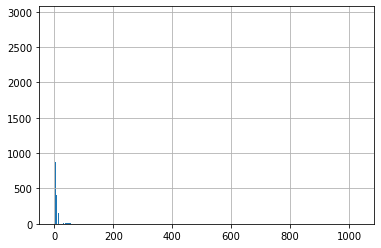

There are 11021 Samples After Outlier Removal


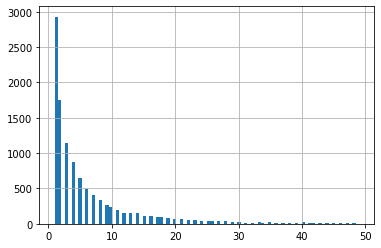

97.1783793316286% of Samples were Kept


In [46]:
data["Num_Arrests"].hist(bins='auto')
data_size=data.shape[0]
print("There are",data_size,"Samples Before Outlier Removal")
plt.show()
data = data[data["Num_Arrests"]<50]
new_size=data.shape[0]
print("There are",new_size,"Samples After Outlier Removal")
data["Num_Arrests"].hist(bins='auto')
plt.show()
print(100*new_size/data_size,"% of Samples were Kept",sep="")

# Create Data Aggregates by County

In [47]:
def agg_all(data):
    new_data = {}
    for colname in ['Num_Arrests','TotalPop','Men','Women','Citizen','Income','IncomeErr', 'Employed']:
        new_data[colname]=data[colname].sum()
    for colname in ['Hispanic', 'White', 'Black', 'Native', 'Asian','IncomePerCap','IncomePerCapErr','Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
            'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk','OtherTransp', 'WorkAtHome',
           'MeanCommute','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']:
        ratio = data[colname]*data['TotalPop']
        new_data[colname]=(ratio.sum()/100)/data.size
    return pd.Series(new_data)

agg_data = data.groupby(['County','Race']).apply(agg_all)

# Attatch Aggregate to Data

In [48]:
agg_data["arrest_ratio"]=agg_data["Num_Arrests"]/agg_data["TotalPop"]
arrest_ratio = list(agg_data["arrest_ratio"])
county = list(agg_data.index.get_level_values(0))
race = list(agg_data.index.get_level_values(1))
agg_data = pd.DataFrame(arrest_ratio, columns=["arrest_ratio"])
agg_data["County"]=county
agg_data["Race"]=race
data = pd.merge(data, agg_data, on=["County","Race"])
data["County_Num_Arrests"]=data["arrest_ratio"]*data["TotalPop"]
data = data.drop("arrest_ratio", axis=1)

# Apply Z Scaling to Continuous Features

In [49]:
num_cols = ['TotalPop','Men','Women','Hispanic','White','Black','Native','Asian','Citizen','Income','IncomeErr','IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service','Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome','MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']
X = data[num_cols].values
data.drop(columns=num_cols)
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_data = pd.DataFrame(X, columns=num_cols)
data[num_cols]=num_data
data = data.dropna()

# Split Data by Race and Into Train/Test Datasets

In [50]:
cols = data.shape[1]
data_white = data[data["Race"]==0].drop("Race", axis=1)
data_non_white=data[data["Race"]==1].drop("Race", axis=1)
data_white_train = data_white.sample(frac=0.8,random_state=101)
data_white_test  = data_white.drop(data_white_train.index)
data_non_white_train = data_non_white.sample(frac=0.8,random_state=101)
data_non_white_test  = data_non_white.drop(data_non_white_train.index)
Xw = data_white_train.iloc[:,1:cols]
yw = data_white_train.iloc[:,0]
Xnw = data_non_white_train.iloc[:,1:cols]
ynw = data_non_white_train.iloc[:,0]
Xwt = data_white_test.iloc[:,1:cols]
ywt = data_white_test.iloc[:,0]
Xnwt = data_non_white_test.iloc[:,1:cols]
ynwt = data_non_white_test.iloc[:,0]

# Encode Categorical Features as Numerical Values

In [51]:
cat_cols = ['County','Borough']
encoder = LabelEncoder()
for var in cat_cols:
    Xw[var] = encoder.fit_transform(Xw[var])
    Xnw[var] = encoder.fit_transform(Xnw[var])
    Xwt[var] = encoder.fit_transform(Xwt[var])
    Xnwt[var] = encoder.fit_transform(Xnwt[var])

# Initial Test of Nonlinear Kernels

In [ ]:
rbfw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White RBF is",-sum(cv)/len(cv))

rbfnw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfnw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White RBF is",-sum(cv)/len(cv))

polyw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polyw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White Polynomial is",-sum(cv)/len(cv))

polynw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polynw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White Polynomial is",-sum(cv)/len(cv))

# Random Search to Tune Hyperparameters

In [ ]:
params = {"C":[0.1,0.5,1,5,10,50,100,500,1000],"epsilon":uniform(1,3),"kernel":["poly","rbf"]}

rscv = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white C", rscv.best_estimator_.get_params()["C"])
print("optimal white epsilon", rscv.best_estimator_.get_params()["epsilon"])
print("optimal white kernel", rscv.best_estimator_.get_params()["kernel"])

rscv2 = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white C", rscv2.best_estimator_.get_params()["C"])
print("optimal non-white epsilon", rscv2.best_estimator_.get_params()["epsilon"])
print("optimal non-white kernel", rscv2.best_estimator_.get_params()["kernel"])


# Run Test Data

In [ ]:
Final_model = SVR(kernel='rbf', C=750, gamma="scale", epsilon=1.5)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

# Try Random Forrest

In [ ]:
model = RandomForestRegressor()
model.fit(Xw, yw)
cv = cross_val_score(model, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White is",-sum(cv)/len(cv))
model.fit(Xnw, ynw)
cv = cross_val_score(model, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White is",-sum(cv)/len(cv))

# Tune Random Forrest Hyperparameters

In [ ]:
params = {"min_samples_split":[2,5,10,15,20,25,30,35], "max_features":[5,10,15,20,25,30]}

rscv = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white min_samples_split", rscv.best_estimator_.get_params()["min_samples_split"])
print("optimal white max_features", rscv.best_estimator_.get_params()["max_features"])

rscv2 = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white min_samples_split", rscv2.best_estimator_.get_params()["min_samples_split"])
print("optimal non-white max_features", rscv2.best_estimator_.get_params()["max_features"])

# Predict Test Data From Best Model

In [31]:
Final_model = RandomForestRegressor(n_estimators=500, min_samples_split=32, max_features=25)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  30.42083038616415
Test MAE for White:  3.29452600039051
Test MSE for Non-White:  53.037397932812546
Test MAE for Non-White:  4.654058652747073


# Create Bias Metric By County and Block

In [52]:
Final_model.fit(Xw, yw)
Xw["predicted_w"] = Final_model.predict(Xw)
Final_model.fit(Xnw, ynw)
Xnw["predicted_nw"] = Final_model.predict(Xnw)
Xnw = Xnw[["CensusTract", "predicted_nw","County_Num_Arrests"]]
Xnw = Xnw.rename(columns={"County_Num_Arrests":"County_Num_Arrests_nw"})
X = pd.merge(left=Xw, right=Xnw,left_on="CensusTract", right_on="CensusTract")
X["Non-White"]=1-X["White"]
X["y"] = np.log(abs(X["predicted_w"]/X["White"]-X["predicted_nw"]/X["Non-White"]))
X = X.replace(np.inf, np.nan)
X = X.dropna()
X_train = X.sample(frac=0.8,random_state=101)
Xt=X.drop(X_train.index)
X=X_train
y = X["y"]
yt=Xt["y"]
X = X.drop(columns=['Hispanic','Black','Native','Asian',"y"])
Xt = Xt.drop(columns=['Hispanic','Black','Native','Asian',"y"])
yc = np.log(abs(X["County_Num_Arrests"]/X["White"]-X["County_Num_Arrests_nw"]/X["Non-White"]))
yct = np.log(abs(Xt["County_Num_Arrests"]/Xt["White"]-Xt["County_Num_Arrests_nw"]/Xt["Non-White"]))
X = X.drop(columns=['White', 'Non-White', 'County_Num_Arrests', 'County_Num_Arrests_nw'], axis=1)
Xt = Xt.drop(columns=['White', 'Non-White', 'County_Num_Arrests', 'County_Num_Arrests_nw'], axis=1)

# Split Data into Training and Validation

In [53]:
X['yb']=y
X['yc']=yc
Xtrain = X.sample(frac=0.9,random_state=101)
Xvalid = X.drop(Xtrain.index)
ybtrain = Xtrain['yb']
yctrain = Xtrain['yc']
ybvalid = Xvalid['yb']
ycvalid = Xvalid['yc']
X = X.drop(columns=['yb','yc'])

# Create Plot of MSE vs Smoothing Factor 

In [ ]:
model = Sequential()
model.add(Dense(50, input_dim = Xtrain.shape[1]-1, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
meansqerrors={}
for i in range(21):
    j = i/20
    ystrain = ybtrain-j*(ybtrain-yctrain)
    ysvalid = ybvalid-j*(ybvalid-ycvalid)
    model.fit(Xtrain.drop(columns=['CensusTract']), ystrain, epochs = 500, batch_size = 16)
    score = model.evaluate(Xvalid.drop(columns=['CensusTract']), ysvalid)
    meansqerrors[j]=score
    print(j,score)
plt.plot(list(meansqerrors.keys()), list(meansqerrors.values()))

# Fit Model to Best Smoothing

In [56]:
ys = y-.15*(y-yc)
yst = yt-.15*(yt-yct)
model = Sequential()
model.add(Dense(50, input_dim = X.shape[1]-1, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_squared_error','mean_absolute_error'])
model.fit(X.drop(columns=['CensusTract']), ys, epochs = 1000, batch_size = 16)

Epoch 1/10
9422/9422 [==============================] - 1s 62us/step - loss: 1.0616 - mean_squared_error: 1.0616 - mean_absolute_error: 0.6937
Epoch 2/10
9422/9422 [==============================] - 1s 59us/step - loss: 0.7295 - mean_squared_error: 0.7295 - mean_absolute_error: 0.5562
Epoch 3/10
9422/9422 [==============================] - 1s 60us/step - loss: 0.6012 - mean_squared_error: 0.6012 - mean_absolute_error: 0.5028
Epoch 4/10
9422/9422 [==============================] - 0s 44us/step - loss: 0.5118 - mean_squared_error: 0.5118 - mean_absolute_error: 0.4610
Epoch 5/10
9422/9422 [==============================] - 0s 44us/step - loss: 0.4465 - mean_squared_error: 0.4465 - mean_absolute_error: 0.4295
Epoch 6/10
9422/9422 [==============================] - 0s 46us/step - loss: 0.4019 - mean_squared_error: 0.4019 - mean_absolute_error: 0.4026
Epoch 7/10
9422/9422 [==============================] - 1s 57us/step - loss: 0.3746 - mean_squared_error: 0.3746 - mean_absolute_error: 0.3873

# Predict Bias of Smoothed Test Sets

In [57]:
_, MSE, MAE = model.evaluate(Xt.drop(columns=['CensusTract']), yst)
print('MSE: ' + str(MSE) + ', MAE: '+ str(MAE))

2355/2355 [==============================] - 0s 32us/step
MSE: 0.37305918804146426, MAE: 0.3660593203931351


# Create Dataset to Visualize Smoothing

In [58]:
block_data = pd.read_csv("census_block_loc.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
X['y']=y
X['ys']=ys
X['yc']=yc
X = X[['CensusTract','y','yc','ys']]
X = pd.merge(left=X, right=block_data, left_on="CensusTract", right_on="tracts")
X = X.drop(columns=["BlockCode","County","State","CensusTract","tracts"])
X

,y,yc,ys,Latitude,Longitude
0,2.027787,1.534278,1.953761,40.841809,-73.874774
1,2.027787,1.534278,1.953761,40.844070,-73.874774
2,2.027787,1.534278,1.953761,40.846332,-73.877940
3,2.027787,1.534278,1.953761,40.846332,-73.874774
4,2.027787,1.534278,1.953761,40.846332,-73.871608
5,2.027787,1.534278,1.953761,40.848593,-73.881106
6,2.027787,1.534278,1.953761,40.848593,-73.877940
7,2.027787,1.534278,1.953761,40.848593,-73.874774
8,2.027787,1.534278,1.953761,40.848593,-73.871608
9,2.027787,1.534278,1.953761,40.850854,-73.881106


# Visualize Smoothing

In [59]:
#put in visuals here from the dataset "block_data"
#real data will be replaced when Erik figures out the proper way to do the smoothing

import gmaps

locations = sample[['latitude','longitude']]
weights = sample['weight']

coords = (40.75, -74.00)
fig = gmaps.figure(center = coords, zoom_level = 12)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

NameError: name 'sample' is not defined